# Quantum Control as Polynomial Optimization: Synthesizing unitary target

This notebook uses multithreadin. Set  

    export JULIA_NUM_THREADS=100
   
before runing Julia

In [2]:
Threads.nthreads()

110

In [3]:
using LinearAlgebra
using QuantumOptics
using DynamicPolynomials
using TSSOS
using QuadGK
using JuMP
using Random
using NLopt

## Quantum system

In [4]:
#= 
Quantum system is taken from 
 https://github.com/q-optimize/c3/blob/master/examples/two_qubits.ipynb

Drift Hamiltonian
=#

H0 = [
    0 0 0;
    0 3.21505101e+10 0;
    0 0 6.23173079e+10
];

H0 ./= norm(H0, Inf)

# Control Hamiltonian
V = [
    0 1 0;
    1 0 1.41421356;
    0 1.41421356 0
]

V ./= norm(V, Inf);

In [5]:
H0

3×3 Matrix{Float64}:
 0.0  0.0       0.0
 0.0  0.515916  0.0
 0.0  0.0       1.0

In [6]:
V

3×3 Matrix{Float64}:
 0.0       0.707107  0.0
 0.707107  0.0       1.0
 0.0       1.0       0.0

## Utilities for working with Polynomials

In [7]:
function ∫(p::AbstractPolynomial, x::PolyVar, x_lower, x_upper)
    
    # get the index of the variable of integration
    ind_x = indexin([x], variables(p))[1]
        
    if isnothing(ind_x)
        # integration valuable is not found among vars
        return p * (x_upper - x_lower)
    end
    
    # get the indefinite integral
    int_p = sum(
        term * x * 1 // (exponents(term)[ind_x] + 1) for term in terms(p)
        init = 0 * x
    )
            
    # get the definite integral
    subs(int_p, x=>x_upper) - subs(int_p, x=>x_lower)
end

function ∫(M::AbstractMatrix, x::PolyVar, x_lower, x_upper)
   map(z -> ∫(z, x, x_lower, x_upper), M) 
end

function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))# if ~isapproxzero(abs(c))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end

square_frobenius_norm (generic function with 1 method)

## Get the truncated Magnus expansion ($n=3$)

In [8]:
@polyvar x[1:3]
@polyvar t[1:3]

# final time
const T = 0.5

function u(t, x)
    # the polynomial shape for control
    sum(x[n] * t^(n - 1) for n = 1:length(x))
end

function A(t, x)
    #=
    The generator of motion entering the Magnus expansion
    =#
    (H0 + V * u(t, x)) / im
end

function commutator(a, b)
    a * b - b * a
end 

# get the partial sum of the Magnus expansion
A₁ = A(t[1], x)
A₂ = A(t[2], x)

Ω = ∫(A₁, t[1], 0, T);

# 2nd term in the Magnus expansion
Ω .+= 1//2 * ∫(∫(
    commutator(A₁, A₂), 
    t[2], 0, t[1]), 
    t[1], 0, T
);

# 3nd term in the Magnus expansion

A₃ = A(t[3], x)

Ω .+= 1//6 * ∫(∫(∫(
    commutator(A₁, commutator(A₂, A₃)) + commutator(commutator(A₁, A₂), A₃),
    t[3], 0, t[2]),
    t[2], 0, t[1]),
    t[1], 0, T
);

## Chebyshve polynomial approximation for $\exp_p(\Omega^{(n)}/2)$ with $n=3$ and $p=5$

In [9]:
using SpecialFunctions

"""
Chebyshev approximation for exp(Ω/2)
"""
function exp_chebyshev(Ω::AbstractMatrix, order::Integer)
    
    Tₙ₋₁ = I
    Tₙ  = Ω
    
    # The first two terms of Chebyshev series for exp
    series = besselj(0, 0.5) * Tₙ₋₁ + 2 * besselj(1, 0.5) * Tₙ
    
    for n=2:order
        Tₙ₊₁  = 2 * Ω * Tₙ + Tₙ₋₁
        
        series .+= 2 * besselj(n, 0.5) * Tₙ₊₁
        
        (Tₙ, Tₙ₋₁) = (Tₙ₊₁, Tₙ) 
    end
    
    series
end

Ω = convert(typeof(A₁), Ω)

exp½Ω = exp_chebyshev(Ω, 5);

## Getting statistic for checking the performance of quantum control formulation as a polynomial optimization

In [10]:
function get_unitary(x::AbstractArray)
    #=
    Get the unitary given the coefficients for the polynomial control
    =#
    basis = NLevelBasis(size(H0)[1])

    𝓗₀ = DenseOperator(basis, basis, H0)
    𝓥 = DenseOperator(basis, basis, V)

    H = LazySum([1., u(0, x)], [𝓗₀, 𝓥])
        
    function 𝓗(t, psi)
        H.factors[2] = u(t, x)
        return H
    end

    _, 𝓤 = timeevolution.schroedinger_dynamic([0, T], identityoperator(basis, basis), 𝓗)
    
    return Matrix(𝓤[2].data)
end


function local_minimize(obj::AbstractPolynomial, init_x::AbstractArray)
    #=
    Perform local minimization of obj polynomial using init_x as initial guess
    =#
    vars = variables(obj)

    @assert length(vars) == length(init_x)
    
    function g(a...)
        # Converting polynomial expression to function to be minimize
        obj(vars => a)
    end
    
    model = Model(NLopt.Optimizer)

    set_optimizer_attribute(model, "algorithm", :LD_MMA)

    set_silent(model)
    @variable(model, y[1:length(vars)])

    # set initial guess
    for (var, init_val) in zip(y, init_x)
        set_start_value(var, init_val)
    end

    register(model, :g, length(y), g; autodiff = true)
    @NLobjective(model, Min, g(y...))
    JuMP.optimize!(model)

    map(value, y)
end

local_minimize (generic function with 1 method)

In [11]:
@time begin
    
n_samples = 1000
Random.seed!(6292022)

# randomly generate the coefficients for the polynomial control 
exact_x = -1 .+ 2 * rand(length(x) * n_samples)
exact_x = reshape(exact_x, (length(x), n_samples))

# The values of objective functions for exact x
obj_exact_x = zeros(n_samples)
    
# The array of target unitaries synthesized by the control x
U_targets = zeros(ComplexF64, n_samples, size(H0)...)

# the polynomial objective at min_x
glob_obj_min_x = zeros(n_samples)

# The global minimum via TSSOS library
tssos_glob_obj_min = zeros(n_samples)

# Frobenius norm difference between target and obtained unitaries
norm_U_target_minus_obtained = zeros(n_samples)

# Frobenius norm difference between target and the truncated Magnus expansion
norm_U_target_minus_expΩ_exact_x = zeros(n_samples)
norm_U_target_minus_expΩ_min_x = zeros(n_samples)

# The normalised overlap of the evolution and the target 
f_PSU = zeros(n_samples) 

# Convergence test for the Magnus expansion for the exact control (convergence_test_exact_x < 1)
convergence_test_exact_x = zeros(n_samples)

# Convergence test for the Magnus expansion for the obtained control (convergence_test_min_x < 1)
convergence_test_min_x = zeros(n_samples)

norm_diff_x = zeros(n_samples)

Threads.@threads for i=1:n_samples
    
    # target unitray
    U_targets[i, :, :] = U_target = get_unitary(exact_x[:, i])
        
    # get the polynomial objective function
    obj = square_frobenius_norm(
        exp½Ω' *  U_target - exp½Ω
    )
    
    # save the value of objective function for exact x
    obj_exact_x[i] = obj(exact_x[:, i])
  
    
    # Get the global minimum via TSSOS library
    opt,sol,data = tssos_first(obj, variables(obj); QUIET = true, solution = true)
    
    previous_sol = sol
    previous_opt = opt
    
    while ~isnothing(sol)
        previous_sol = sol
        previous_opt = opt
            
        opt,sol,data = tssos_higher!(data; QUIET = true, solution = true)
    end
    
    tssos_glob_obj_min[i] = previous_opt
    min_x = previous_sol
    
    # refine the estimate by local minimization
    #min_x = local_minimize(obj, min_x)
    
    # the polynomial objective at min_x
    glob_obj_min_x[i] = tssos_glob_obj_min[i]
        
    # get the Frobenius norm difference between target and obtained unitaries
    U_star = get_unitary(min_x)
    norm_U_target_minus_obtained[i] = norm(U_target - U_star)

    # The normalised overlap of the evolution and the target 
    f_PSU[i] = abs(tr(U_target' * U_star)) / size(U_star)[1]
        
    # check the accuracy of the Magnus expansion
    Ω_exact_x = convert(Matrix{ComplexF64}, subs(Ω, x=>exact_x[:, i]))
    norm_U_target_minus_expΩ_exact_x[i] = norm(U_target - exp(Ω_exact_x))

    Ω_min_x = convert(Matrix{ComplexF64}, subs(Ω, x=>min_x))
    norm_U_target_minus_expΩ_min_x[i] = norm(U_target - exp(Ω_min_x))
    
    # Convergence test for the Magnus expansion for the exact control
    convergence_test_exact_x[i] = quadgk(t -> opnorm(A(t, exact_x[:, i])), 0, T)[1] / π

    # Convergence test for the Magnus expansion for the obtained control
    convergence_test_min_x[i] = quadgk(t -> opnorm(A(t, min_x)), 0, T)[1] / π    
    
    norm_diff_x[i] = norm(exact_x[:, i] - min_x)
end
    
end

************************TSSOS************************
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
************************TSSOS************************
************************TSSOS************************
************************TSSOS************************
************************TSSOS************************
************************TSSOS************************
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
************************TSSOS************************
************************TSSOS************************
************************TSSOS************************
************************TSSOS************************
************************TSSOS************************
************************TSSOS************************
****************

optimum = 2.7162539974018997e-8
optimum = 1.8420167322061163e-8
Global optimality certified!
Global optimality certified!
Global optimality certified!
optimum = 2.530805584523949e-8
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 7.578155790219051e-9
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 2.7849492628724398e-8
Global optimality certified!
optimum = 2.9544787787560702e-8
Global optimality certified!
optimum = 3.2801455050111673e-8
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 2.1120834418799358e-8
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 1.3673959908053577e-8
Global optimality certified!
optimum = 2.8656032955648133e-8
Global optimality certified!
optimum = 2.5018049083742913e-8
Global optimality certified!
optim

optimum = 5.1543387091298566e-8
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 1.55137262824784e-8
Global optimality certified!
optimum = 1.7097567209091456e-8
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 2.05265902747378e-8
No higher TSSOS hierarchy!
Global optimality certified!
optimum = 2.7037234982567425e-8
optimum = 8.143147020286988e-9
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 1.155239384064019e-8
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 2.0602319412307442e-8
optimum = 2.3280022979996048e-8
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 2.0655878363477786e-8
No higher TSSOS hierarchy!
Global optimality certified!
optimum = 5.011160227841324e-8
Global optimality certified!
optimum = 8.435421284194449e-8
Global o

optimum = 2.3858400742857635e-8
No higher TSSOS hierarchy!
Global optimality certified!
optimum = 2.5702987969143044e-8
No higher TSSOS hierarchy!
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 3.2836304772855004e-8
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = 8.77534129103646e-8
Global optimality certified!
optimum = 1.0365663615106856e-8
Global optimality certified!
optimum = 1.939477900571877e-8
optimum = 2.661537642196938e-8
optimum = 1.3958423070232004e-8
Global optimality certified!
Global optimality certified!
Global optimality certified!
optimum = 1.3585111284602999e-8
optimum = 3.145144553377976e-8
Global optimality certified!
Global optimality certified!
optimum = 1.4829846125176572e-7
optimum = 1.4083613793632117e-8
Global optim

optimum = 3.5725027034020135e-8
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 2.77965012937596e-7
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 1.2493671443361184e-8
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = 1.7292560975889783e-8
Global optimality certified!
optimum = 1.8710711303618336e-8
Global optimality certified!
optimum = 1.1526148715087061e-8
optimum = 5.075145996655175e-8
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 1.5154860066788714e-8
optimum = 1.4636898341260442e-8
Global optimality certified!
Global optimality certified!
optimum = 1.893818380372995e-8
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 2.7388190966781364e-8
optimum = 1.4835730955860617e-8
Global opti

optimum = 1.5148968101905702e-8
optimum = 2.7528317740349593e-8
optimum = 3.316998121116547e-8
optimum = 2.260870536372252e-8
optimum = 1.4975344145202676e-8
optimum = 3.0015397202754606e-8
optimum = 2.7868783668771217e-8
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 1.1823597835498264e-8
optimum = 1.5467329132022312e-8
optimum = 2.1095743160772538e-8
optimum = 1.760953573142912e-7
optimum = 1.8187180177217663e-8
optimum = 1.2769391067356001e-8
optimum = 3.3391748523771695e-8
optimum = 4.1970033634057675e-8
optimum = 2.6481833871831556e-8
optimum = 5.1592892354197735e-8
Global optimality certified!
optimum = 2.7117782662392535e-8
optimum = 2.2665905022499275e-8
optimum = 1.253174192862706e-8
optimum = 4.702688137675313e-8
optimum = 1.5068428613894756e-8
Global optimality certified!
optimum = 2.2364656974790644e-8
optimum = 1.2877860868901559e-8
optimum = 3.187044674715777e-8
Global optimality certified!
optimum = 2.849770028335232e-7
optimum = 1.9247723043410388e-8


optimum = 4.3592010034951915e-8
optimum = 6.354415090938935e-8
optimum = 1.4193284449639373e-8
optimum = 2.8933304723424453e-8
Global optimality certified!
optimum = 1.652318447839648e-8
optimum = 2.892849841767499e-8
optimum = 3.805142885541093e-8
optimum = 2.1226823781449282e-7
Global optimality certified!
optimum = 1.0316365957112163e-8
optimum = 2.327209971497241e-8
optimum = 2.5484645849685082e-8
Global optimality certified!
optimum = 3.688186166631783e-8
Global optimality certified!
optimum = 1.2957367702744015e-7
Global optimality certified!
optimum = 3.212031905476111e-8
optimum = 2.0840892712828415e-8
optimum = 3.323253885123988e-8
optimum = 1.3915329063794228e-8
optimum = 6.124679329004756e-8
optimum = 3.4251206014783696e-8
optimum = 2.0496856518958017e-8
optimum = 3.278459169084844e-8
optimum = 1.8338959048938046e-8
Global optimality certified!
optimum = 3.927569539923093e-8
optimum = 4.1043546380997856e-8
optimum = 2.744730568216021e-8
Global optimality certified!
optimum =

optimum = 1.2788679969887494e-8
optimum = 1.0919566378259484e-8
optimum = 2.914852032423078e-8
optimum = 4.2804876664044686e-8
Global optimality certified!
optimum = 2.379597602947377e-8
optimum = 2.0179503039957585e-8
optimum = 8.484333285885356e-9
optimum = 2.3500680264595375e-8
Global optimality certified!
Global optimality certified!
optimum = 2.2532131337740744e-8
optimum = 2.8977983390919358e-8
Global optimality certified!
Global optimality certified!
optimum = 1.3085387935727298e-8
optimum = 2.1252027295329978e-8
optimum = 2.857092355948102e-8
optimum = 2.2064740159685804e-8
optimum = 1.6945237902983603e-8
Global optimality certified!
Global optimality certified!
optimum = 5.081905594015727e-8
Global optimality certified!
Global optimality certified!
Global optimality certified!
optimum = 9.973593243485717e-9
optimum = 3.3393378200356434e-8
Global optimality certified!
Global optimality certified!
Global optimality certified!
optimum = 4.8491659984518063e-8
Global optimality cer

optimum = 2.474569447670884e-8
optimum = 3.5900611720558385e-8
optimum = 1.9101626138933022e-8
optimum = 1.741563205027824e-8
optimum = 8.190940810839754e-8
optimum = 1.3066765619421374e-8
Global optimality certified!
Global optimality certified!
optimum = 1.5147444227196917e-8
optimum = 1.233688668662463e-8
optimum = 7.966301100430961e-9
optimum = 1.2954064672857318e-8
optimum = 1.1871598055669586e-8
optimum = 1.0296716817415314e-8
optimum = 4.308896125046262e-8
optimum = 4.008237379617043e-8
optimum = 2.2982653526186012e-8
optimum = 4.198712565111839e-8
Global optimality certified!
optimum = 2.0415742303115415e-8
Global optimality certified!
optimum = 2.7299993654956213e-8
Global optimality certified!
Global optimality certified!
optimum = 2.5693310287555897e-8
Global optimality certified!
optimum = 3.608362158764339e-8
Global optimality certified!
optimum = 5.0597884487322457e-8
optimum = 1.8784538254573318e-8
Global optimality certified!
Global optimality certified!
optimum = 8.142

optimum = 4.2451784383758136e-8
optimum = 1.9882412602473937e-8
optimum = 2.6311917450324422e-8
optimum = 1.7174976419409216e-8
optimum = 2.316919080465208e-8
optimum = 2.5824516603944205e-8
optimum = 1.342051539570878e-8
optimum = 1.4662112261902271e-8
optimum = 2.9158960697632817e-8
optimum = 3.7094987972462296e-8
optimum = 3.013843234441971e-8
optimum = 4.661714992957599e-8
optimum = 1.4428216573985677e-8
optimum = 2.4911697936383056e-7
optimum = 2.4500021405410262e-8
optimum = 2.809058116024324e-8
optimum = 7.298639247914043e-8
optimum = 5.968737563097857e-9
optimum = 4.5118184984916246e-8
optimum = 1.8887599479637738e-8
optimum = 2.4995606231409594e-8
optimum = 4.102274055633843e-8
optimum = 5.3208467033833886e-8
optimum = 2.3748856034469076e-8
Global optimality certified!
Global optimality certified!
optimum = 1.4776047452246226e-8
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
Globa

## Saving results

In [12]:
using HDF5


h5open("results.hdf5", "w") do fid
    fid["U_targets"] = U_targets
    fid["exact_x"] = exact_x
    fid["obj_exact_x"] = obj_exact_x
    fid["tssos_glob_obj_min"] = tssos_glob_obj_min
    fid["norm_U_target_minus_obtained"] = norm_U_target_minus_obtained
    fid["f_PSU"] = f_PSU
    fid["convergence_test_exact_x"] = convergence_test_exact_x
    fid["convergence_test_min_x"] = convergence_test_min_x
end;

## Analysis

In [31]:
using PyPlot

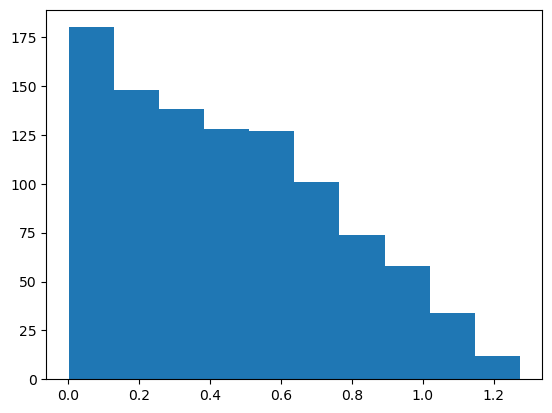

In [32]:
hist(norm_diff_x)
show()

### Actual global minimum vs global minimum estimate via TSSOS

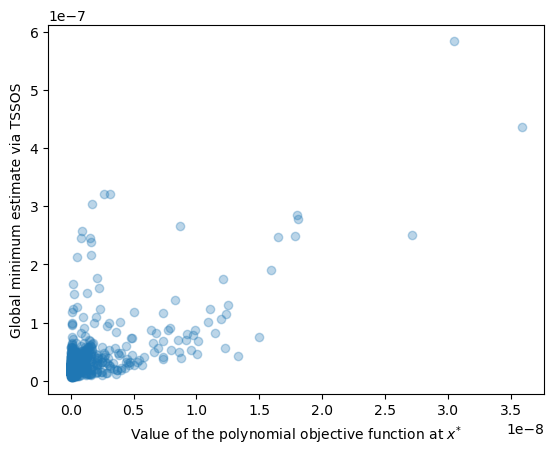

In [45]:
scatter(obj_exact_x, glob_obj_min_x, alpha=0.3)

#lower = min(minimum(obj_exact_x), minimum(glob_obj_min_x))
#higher = maximum(obj_exact_x)
#plot!([lower, higher], [lower, higher], label=nothing)

xlabel("Value of the polynomial objective function at " * L"x^{*}")
ylabel("Global minimum estimate via TSSOS")

savefig("Fig_TSSOSvsXstar.pdf")

show()

### Obtained unitray $\hat{U}$ vs the target $U^{\star}$

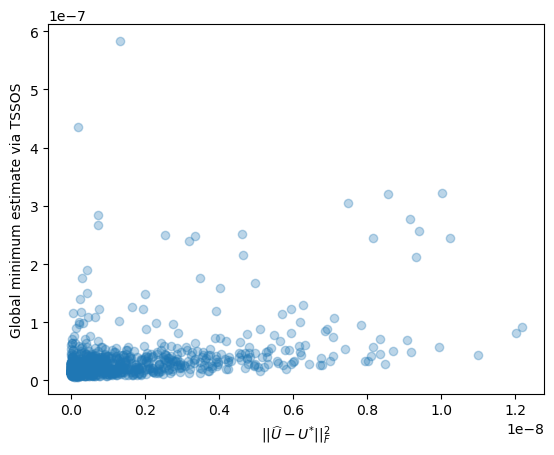

In [50]:
scatter(norm_U_target_minus_obtained .^ 2, glob_obj_min_x, alpha=0.3)
#lower = min(minimum(norm_U_target_minus_obtained .^ 2), minimum(glob_obj_min_x))
#higher = maximum(norm_U_target_minus_obtained .^ 2)
#plot!([lower, higher], [lower, higher], label=nothing)
xlabel(L"\|\| \widehat{U} - U^{*} \|\|_F^2" )
ylabel("Global minimum estimate via TSSOS")
#savefig("Fig_PolynomialOptVsCoherenControl.pdf")
show()

### Infidelity vs the norm difference

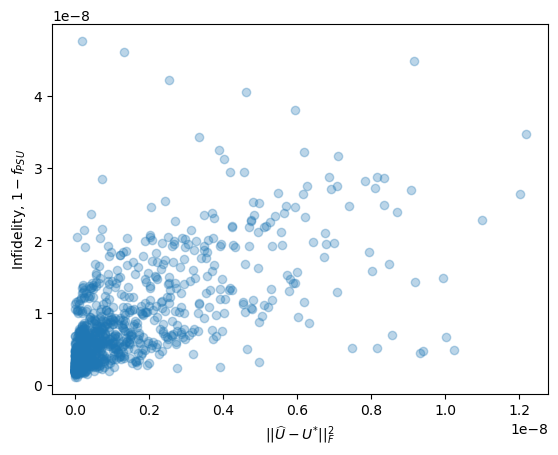

In [53]:
scatter(norm_U_target_minus_obtained .^ 2, 1 .- f_PSU, alpha=0.3)
xlabel(L"\|\| \widehat{U} - U^{*} \|\|_F^2" )
ylabel("Infidelity, " * L"1 - f_{PSU}")
show()

### Testing approximated exp vs exact exp

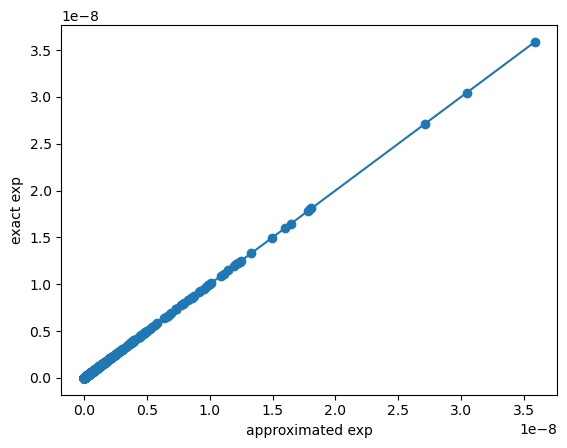

In [55]:
scatter(obj_exact_x, norm_U_target_minus_expΩ_exact_x .^ 2, label=nothing)
lower = min(minimum(norm_U_target_minus_expΩ_exact_x .^ 2), minimum(obj_exact_x))
higher = max(maximum(norm_U_target_minus_expΩ_exact_x .^ 2), maximum(obj_exact_x))
plot([lower, higher], [lower, higher], label=nothing)
xlabel("approximated exp")
ylabel("exact exp")
show()

### Convergence tests

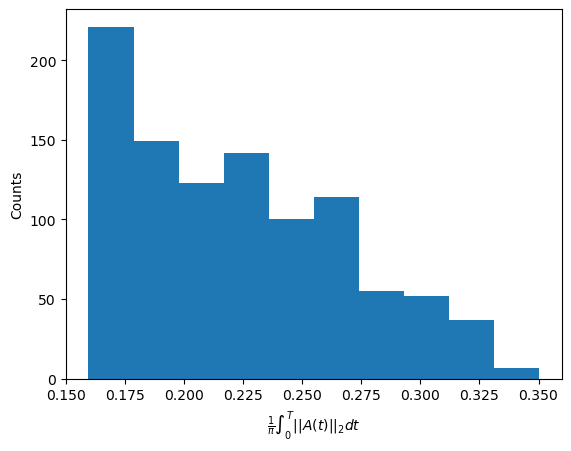

In [61]:
hist(convergence_test_exact_x)
ylabel("Counts")
xlabel(L"\frac{1}{\pi} \int_0^T || A(t) ||_2 dt") #, guidefontsize=11,)
#annotate([(0.35, 200, text("(A)"))])
#savefig("Fig_ConvergenceTestXstar.pdf")
show()

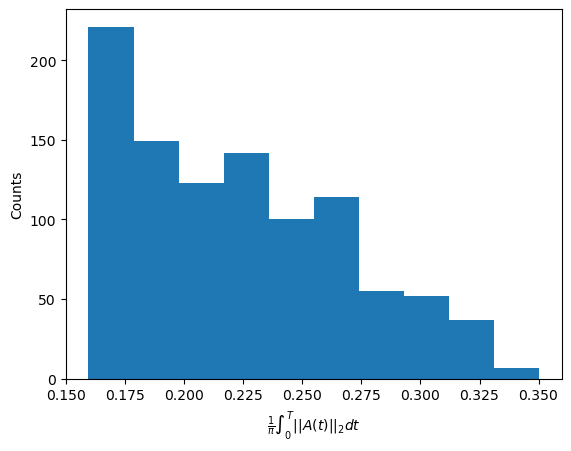

In [66]:
hist(convergence_test_min_x)
xlabel(L"\frac{1}{\pi} \int_0^T || A(t) ||_2 dt")
ylabel("Counts")
#annotate!([(0.35, 200, text("(B)"))])
#savefig("Fig_ConvergenceTestXHat.pdf")
show()